In [119]:
import shapely#.geometry import Point, LineString
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import random

import warnings
warnings.filterwarnings('ignore')

In [120]:
gdf = gpd.read_file("./MEX/MEX_ADM2_fixedInternalTopology.shp")
gdf = gdf[['shapeID', 'geometry']]

match = pd.read_csv("./gB_IPUMS_match.csv")
match = match[['shapeID', 'MUNI2015']]
ref_dict = dict(zip(match['MUNI2015'], match['shapeID']))

df = pd.read_csv("./mexico2010.csv")
df = df[['GEO2_MX', 'sum_income', 'total_pop', 'unrel_ppl', 'perc_urban', 'sum_num_intmig']]
df['GEO2_MX'] = df['GEO2_MX'].astype(str).str.replace("484", "").astype(int).map(ref_dict)
df = df.rename(columns = {'GEO2_MX': 'shapeID'})

<Figure size 720x720 with 0 Axes>

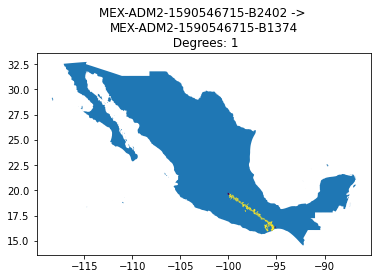

In [124]:
class GeoPath():

    def __init__(self, sending_id, recieving_id, gdf, df, x = False, degrees = 1):


        """
        TO-DO EDGE CASES:
            1) When shortest path crosses a body of water (or another countries border) need to reroute to shortest path that stays on land/in-country
            2) Need to prevent municiaplties that are too far north/south of sending/recieivng from being included in neighbor list
                - I think this is going to involve calculating a trajectory (i.e.. are they traveling north/south) and then maybe buffering the relavent sides of sending/recieiving                    nodes to prevent muni's within the buffer from being included
        """

        self.df = df
        self.gdf = gdf
        self.degrees = degrees
        self.sending_id = sending_id
        self.recieving_id = recieving_id
        self.shortest_distance_nodes = self.__get_shortest_distance_nodes()
        self.adj_list = self.__get_spatial_neighbors()


    def __calc_centroid_x(self, x):
        return x.centroid.x
    
    def __calc_centroid_y(self, x):
        return x.centroid.y

    def calc_shortest_line(self, xs, ys):
        line = shapely.geometry.LineString([shapely.geometry.Point(xs[0], ys[0]), shapely.geometry.Point(xs[1], ys[1])]).wkt
        new_row = pd.DataFrame(columns = ['shapeID', 'geometry', 'c_long', 'c_lat'])
        new_row['shapeID'], new_row['geometry'], new_row['c_long'], new_row['c_lat'] = ['line'], [line], [0], [0]
        new_row['geometry'] = new_row['geometry'].apply(shapely.wkt.loads)
        new_row = gpd.GeoDataFrame(new_row, geometry='geometry')
        return new_row


    def __get_intersection(self):
        inp, res = self.gdf.sindex.query_bulk(self.line.geometry, predicate='intersects')
        intersected = self.gdf.loc[res]
        return intersected


    def __get_shortest_distance_nodes(self):
        gdf_temp = self.gdf[self.gdf['shapeID'].isin([sending_id, recieving_id])]
        gdf_temp['c_long'] = gdf_temp['geometry'].apply(lambda x: self.__calc_centroid_x(x))
        gdf_temp['c_lat'] = gdf_temp['geometry'].apply(lambda x: self.__calc_centroid_y(x))
        self.line = self.calc_shortest_line(gdf_temp['c_long'].to_list(), gdf_temp['c_lat'].to_list()).buffer(.001)
        intersected = self.__get_intersection()
        return intersected


    def __make_neighbor_list(self, x):
        return self.gdf[~self.gdf.geometry.disjoint(x)].shapeID.tolist()


    def __get_spatial_neighbors(self):

        self.degree_dict = {}
        self.neighbors_gdf = self.shortest_distance_nodes
        self.neighbors_gdf = self.neighbors_gdf[~self.neighbors_gdf['shapeID'].isin([self.sending_id, self.recieving_id])]

        self.degree_dict[0] = [self.sending_id, self.recieving_id]
        self.degree_dict[1] = self.shortest_distance_nodes['shapeID'].to_list()

        for i in range(self.degrees - 1):

            self.neighbors_gdf['neighbors'] = self.neighbors_gdf.geometry.apply(lambda x: self.__make_neighbor_list(x))
            all_neighbors = dict(zip(self.neighbors_gdf['shapeID'], self.neighbors_gdf['neighbors']))

            u_vals = list(set([item for sublist in all_neighbors.values() for item in sublist]))
            all_in_degree_dict = list(set([item for sublist in self.degree_dict.values() for item in sublist]))
            new_for_degree_dict = [i for i in u_vals if i not in all_in_degree_dict]
            self.degree_dict[i + 2] = new_for_degree_dict

            remove_vals = [i for i in u_vals if i not in all_neighbors.keys()]
            for k,v in all_neighbors.items():
                to_remove = [j for j in v if j in remove_vals]
                for tr in to_remove:
                    all_neighbors[k] = [i for i in all_neighbors[k] if i not in tr]


            all_munis = list(all_neighbors.keys()) + u_vals
            self.neighbors_gdf = self.gdf[self.gdf['shapeID'].isin(all_munis)]
            self.neighbors_gdf = self.neighbors_gdf[~self.neighbors_gdf['shapeID'].isin([self.sending_id, self.recieving_id])]

        to_append = self.shortest_distance_nodes[self.shortest_distance_nodes['shapeID'].isin([self.sending_id, self.recieving_id])]
        self.neighbors_gdf = self.neighbors_gdf.append(to_append)

            

    def __color_poys(self, x):
        if x == self.sending_id or x == self.recieving_id: 
            return 1
        else: 
            return 0


    def __map_degree_column(self, x):
        """
        Returns the number of degrees away from the target_id a municipality is
        """
        for k,v in self.degree_dict.items():
            if x in v:
                return k


    def show(self, adm0 = None):

        self.neighbors_gdf['color'] = self.neighbors_gdf['shapeID'].apply(lambda x: self.__map_degree_column(x))

        if adm0 is None:

            plt.figure(1, figsize=(10, 10)) 
            self.neighbors_gdf.plot(column = 'color', cmap = 'viridis')
            plt.title(self.sending_id + "->" + self.recieving_id + "\n Degrees: " + str(self.degrees))

        else:

            plt.figure(1, figsize=(10, 10)) 
            base = adm0.plot()
            self.neighbors_gdf.plot(ax = base, column = 'color', cmap = 'viridis')
            plt.title(self.sending_id + " -> \n" + self.recieving_id + "\n Degrees: " + str(self.degrees))


sending_id = random.choice(df['shapeID'].to_list())
recieving_id = random.choice(df['shapeID'].to_list())

degrees = random.randint(1, 4)

g = GeoPath(sending_id, recieving_id, gdf, df, degrees = degrees).show(adm0 = gpd.read_file("./geoBoundariesSimplified-3_0_0-MEX-ADM0-shp/geoBoundariesSimplified-3_0_0-MEX-ADM0.shp"))


In [100]:
gd = pd.DataFrame(g)
gd.columns = ['shape']


gd[gd['shape'] == True].reset_index()['index'].values
# gd
# gd['shape'].unique()

array([], dtype=int64)

In [60]:
gdf.shape

(2458, 2)

In [96]:
from shapely.geometry import Polygon, LineString, Point
s = gpd.GeoSeries(
    [
        Polygon([(0, 0), (2, 2), (0, 2)]),
        LineString([(0, 0), (2, 2)]),
        LineString([(2, 0), (0, 2)]),
        Point(0, 1),
    ],
)
s2 = gpd.GeoSeries(
    [
        LineString([(1, 0), (1, 3)]),
        LineString([(2, 0), (0, 2)]),
        Point(1, 1),
        Point(0, 1),
    ],
    index=range(1, 5),
)

In [97]:
line = LineString([(-1, 1), (3, 1)])

In [98]:
s.intersects(line)

0    True
1    True
2    True
3    True
dtype: bool